In [1]:
#pip install mtcnn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 49.4 MB 101 kB/s eta 0:00:013     |█████████████████████████████   | 44.7 MB 7.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/broilo/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from numpy import load
from numpy import expand_dims
from mtcnn.mtcnn import MTCNN
from typing import Tuple
from typing import List
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
import requests
from io import BytesIO
import pickle
#from google.colab import drive
#drive.mount('/content/drive')


In [40]:
TRAIN_SET_PATH = '/home/broilo/Documents/Drive/UFC-model-tutorial-branch/ufc-project/2-ufc-fighters/train'
# '/content/drive/My Drive/UFC-model-tutorial-branch/ufc-project/2-ufc-fighters/train'
TESTE_SET_PATH = '/home/broilo/Documents/Drive/UFC-model-tutorial-branch/ufc-project/2-ufc-fighters/test'
#' /content/drive/My Drive/UFC-model-tutorial-branch/ufc-project/2-ufc-fighters/test'
PATH_TO_LOAD_FACENET_MODEL = '/home/broilo/Documents/Drive/UFC-model-tutorial-branch/ufc-project/FaceNet/model/facenet_keras.h5'
# '/content/drive/My Drive/UFC-model-tutorial-branch/ufc-project/FaceNet/model/facenet_keras.h5'
UFC_PROJECT_PATH = '/home/broilo/Documents/Drive/UFC-model-tutorial-branch/'
# '/content/drive/My Drive/UFC-model-tutorial-branch/'
FACES_PATH = '/home/broilo/Documents/Drive/UFC-model-tutorial-branch/ufc-project/2-ufc-fighters/'
# '/content/drive/My Drive/UFC-model-tutorial-branch/ufc-project/2-ufc-fighters/'
TRAINED_MODEL = "trained_model.sav"
TRAINED_OUT_ENCODER = "trained_out_encoder.sav"
URL_TEST = 'https://i.pinimg.com/originals/8b/95/b5/8b95b5db2d2b315dd75ddeddfe388538.jpg'

In [11]:
facenet_model = load_model(PATH_TO_LOAD_FACENET_MODEL, compile = False)

In [12]:
detector = MTCNN()

In [13]:
def extract_image_from_path(filename: str) -> np.ndarray:
	
  #file = os.path.join(global_image_path, filename)
  image = Image.open(filename).convert('RGB')
  pixels = np.asarray(image)
  
  return pixels

In [14]:
def extract_face_from_image_array(image_array: np.ndarray) -> np.ndarray:
  faces = detector.detect_faces(image_array)
  x1, y1, width, height = faces[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  face = image_array[y1:y2, x1:x2]
  
  return face

In [15]:
def resize_extracted_face(image_array: np.ndarray, required_size: Tuple[int, int] = (160, 160)) -> np.ndarray:
    image = Image.fromarray(image_array).resize(required_size)
    face_array = asarray(image)
  
    return face_array

In [16]:
def extract_face(filename: str, required_size: Tuple[int, int] = (160, 160)) -> np.ndarray:
  image = extract_image_from_path(filename)
  face = extract_face_from_image_array(image)
  resized_face = resize_extracted_face(face)

  return resized_face

In [17]:
def load_faces(directory: str) -> List[np.ndarray]:
  """ Load images and extract faces for all images in a directory """

  faces = list()

  # enumerate files
  for filename in listdir(directory):
    # path
    path = directory + '/' + filename

    # get face
    face = extract_face(path)

    # store
    faces.append(face)

  return faces

In [18]:
def load_dataset(directory: str) \
      -> (List[np.ndarray], np.ndarray):
  """ Load a dataset that contains one subdir for each class that in turn contains images """
	
  X, y = list(), list()
	
  # enumerate folders, on per class
  for subdir in listdir(directory):
    # path
    path = directory + '/' + subdir + '/'

    # skip any files that might be in the dir
    if not isdir(path):
      continue

    # load all faces in the subdirectory
    faces = load_faces(path)

    # create labels
    labels = [subdir for _ in range(len(faces))]

    # store
    X.extend(faces)
    y.extend(labels)
	
  return asarray(X), asarray(y)

In [19]:
def create_train_test_data():

    # load train dataset
    trainX, trainy = load_dataset(TRAIN_SET_PATH)

    # load test dataset
    testX, testy = load_dataset(TESTE_SET_PATH)

    # save arrays to one file in compressed format
    return trainX, trainy, testX, testy

In [20]:
def get_embedding(facenet_model, face_pixels):
  """ Get the face embedding for one face """

  # scale pixel values
  face_pixels = face_pixels.astype('float32')

  # standardize pixel values across channels (global)
  mean, std = face_pixels.mean(), face_pixels.std()
  face_pixels = (face_pixels - mean) / std

  # transform face into one sample
  samples = expand_dims(face_pixels, axis=0)

  # make prediction to get embedding
  yhat = facenet_model.predict(samples)

  return yhat[0]

In [21]:
def create_embedding_data_set(trainX, trainy, testX, testy):
	# convert each face in the train set to an embedding
	newTrainX = list()
	for face_pixels in trainX:
		embedding = get_embedding(facenet_model, face_pixels)
		newTrainX.append(embedding)
	newTrainX = asarray(newTrainX)

	# convert each face in the test set to an embedding
	newTestX = list()
	for face_pixels in testX:
		embedding = get_embedding(facenet_model, face_pixels)
		newTestX.append(embedding)
	newTestX = asarray(newTestX)

	return newTrainX, trainy, newTestX, testy

In [22]:
def normalize_input_vector(trainX, testX):
    # normalize input vectors
    in_encoder = Normalizer(norm = 'l2')
    trainX = in_encoder.transform(trainX)
    testX = in_encoder.transform(testX)

    return trainX, testX

In [23]:
def enconde_targets(trainy, testy):
    # label encode targets
    out_encoder = LabelEncoder()
    out_encoder.fit(trainy)
    trainy = out_encoder.transform(trainy)
    testy = out_encoder.transform(testy)

    return trainy, testy, out_encoder

In [24]:
def train_model(trainX, trainy):

    # fit model
    model = SVC(kernel = 'linear', probability = True)
    model.fit(trainX, trainy)

    return model

In [25]:
def predict_fighters(model):
    # predict
    yhat_train = model.predict(trainX)
    yhat_test = model.predict(testX)

    return yhat_train, yhat_test

In [26]:
def print_scores(model):
    # score
    score_train = accuracy_score(trainy, yhat_train)
    score_test = accuracy_score(testy, yhat_test)
    print("Score train: ", score_train)
    print("Score test: ", score_test)

In [27]:
def get_image_array_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    pixels = np.asarray(img)
    return pixels

In [28]:
def extract_face_from_url(url):
    image_array = get_image_array_from_url(url)
    face_array = extract_face_from_image_array(image_array)
    resized_face_array = resize_extracted_face(face_array)

    return resized_face_array

In [29]:
def normalize_one_array(image_array):
    in_encoder = Normalizer(norm = 'l2')
    normalized_array = in_encoder.transform(image_array)

    return normalized_array

In [30]:
def test_model_on_selected_photo(url, model, out_encoder):
    face_array = extract_face_from_url(url)
    face_embedding = get_embedding(facenet_model, face_array)
    face_embedding = expand_dims(face_embedding, axis = 0)
    face_embedding_normalized = normalize_one_array(face_embedding)

    #sample = expand_dims(face_embedding_normalized, axis = 0)
    
    yhat_class = model.predict(face_embedding_normalized)
    yhat_prob = model.predict_proba(face_embedding_normalized)

    #photo_name = out_encoder.inverse_transform([photo_class])

    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)

    # plot for fun
    plt.imshow(face_array)
    plt.title("Predicted: {0} Probability {1:.3f}%".format(predict_names[0], class_probability))
    plt.show()

In [31]:
def create_embedding_data_set_and_train_model():
    trainX, trainy, testX, testy = create_train_test_data()
    trainX, trainy, testX, testy = create_embedding_data_set(trainX, trainy, 
                                                             testX, testy)
    trainX, testX = normalize_input_vector(trainX, testX)
    trainy, testy, out_encoder = enconde_targets(trainy, testy)

    model = train_model(trainX, trainy)

    return model, out_encoder

In [32]:
#model, out_encoder = create_embedding_data_set_and_train_model()

In [33]:
def save_pickle(model, out_encoder):
  pickle.dump(model, open(UFC_PROJECT_PATH + TRAINED_MODEL, 'wb'))
  pickle.dump(out_encoder, open(UFC_PROJECT_PATH + TRAINED_OUT_ENCODER, 'wb'))

In [34]:
#save_pickle(model, out_encoder)

In [42]:
def load_pickle():
  load_model = pickle.load(open(UFC_PROJECT_PATH + TRAINED_MODEL, 'rb'))
  load_out_encoder = pickle.load(open(UFC_PROJECT_PATH + TRAINED_OUT_ENCODER, 'rb'))

  return load_model, load_out_encoder

In [45]:
load_model, load_out_encoder = load_pickle()

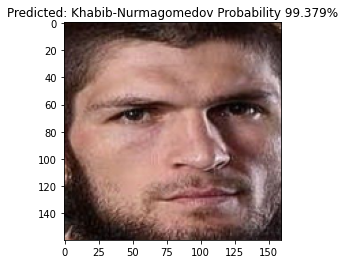

In [46]:
test_model_on_selected_photo(URL_TEST, load_model, load_out_encoder)